In [1]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import skimage
from scipy.ndimage import gaussian_filter
from PIL import Image, ExifTags
import exifread
import imageio
from datetime import timedelta
import pickle
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import scipy.fft
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from minisom import MiniSom
import json
from datetime import datetime

sys.path.append('../modules')
import processing
from run_handler import Campaign, Run
from image_handler import Picture

In [2]:
campaign = Campaign('../configs/TestCampaign02.json')

In [3]:
force_calculate = False
for i, run in enumerate(campaign.runs):
    print(f'Loading Run {i+1} of {len(campaign.runs)} with {len(run.pictures)} images')
    if force_calculate:
        run.calc_image_data()
    else:
        if run.load_image_data():
            continue
        else:
            run.calc_image_data()

Loading Run 1 of 3 with 203 images
Loading Run 2 of 3 with 70 images
Loading Run 3 of 3 with 109 images


c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return 

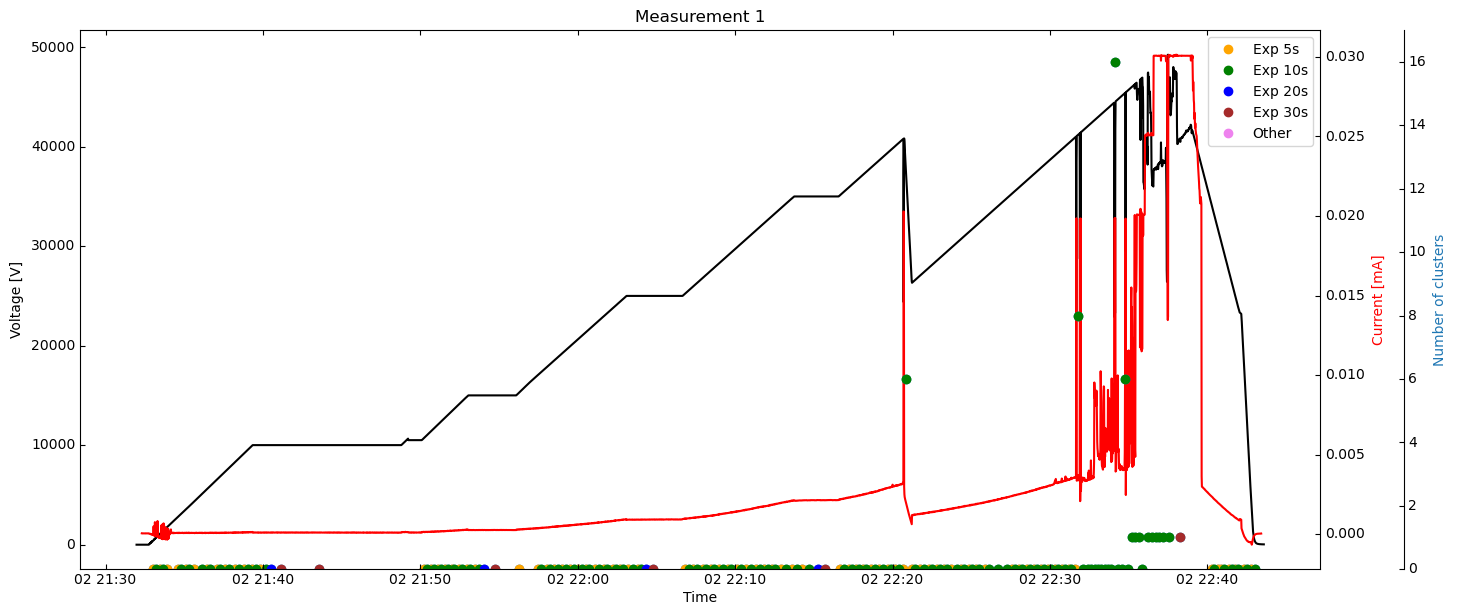

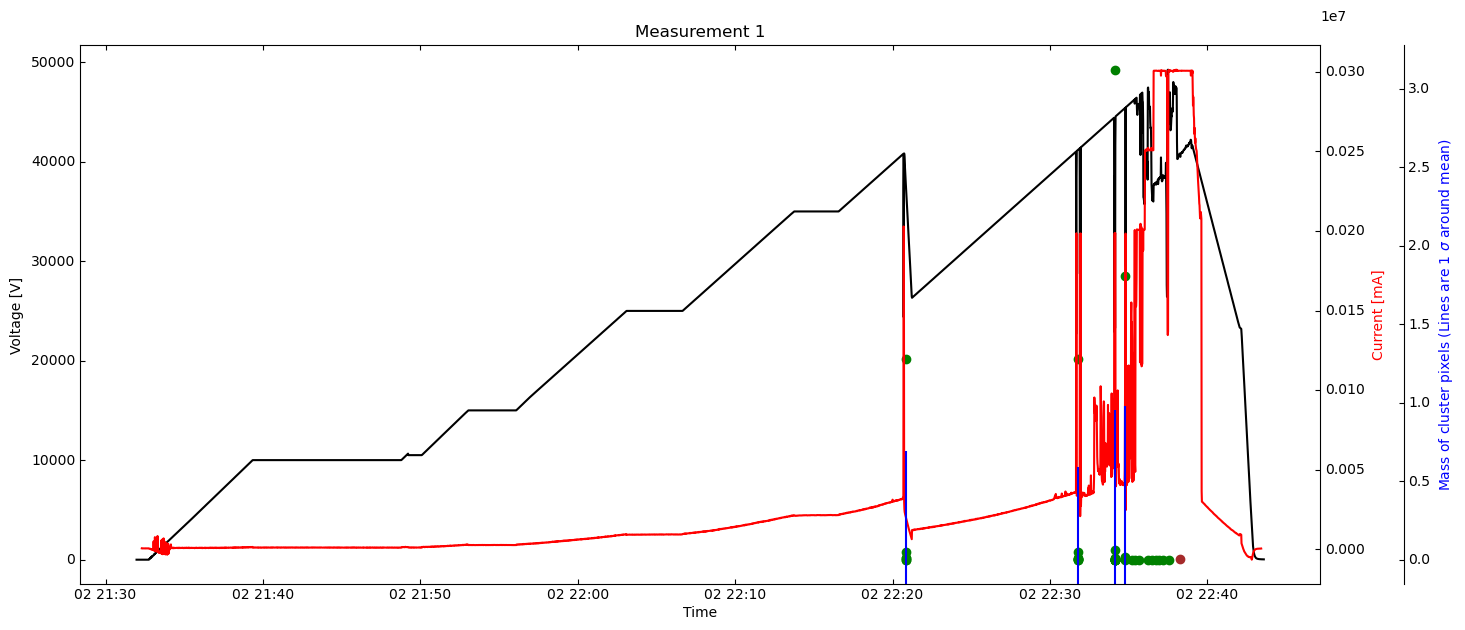

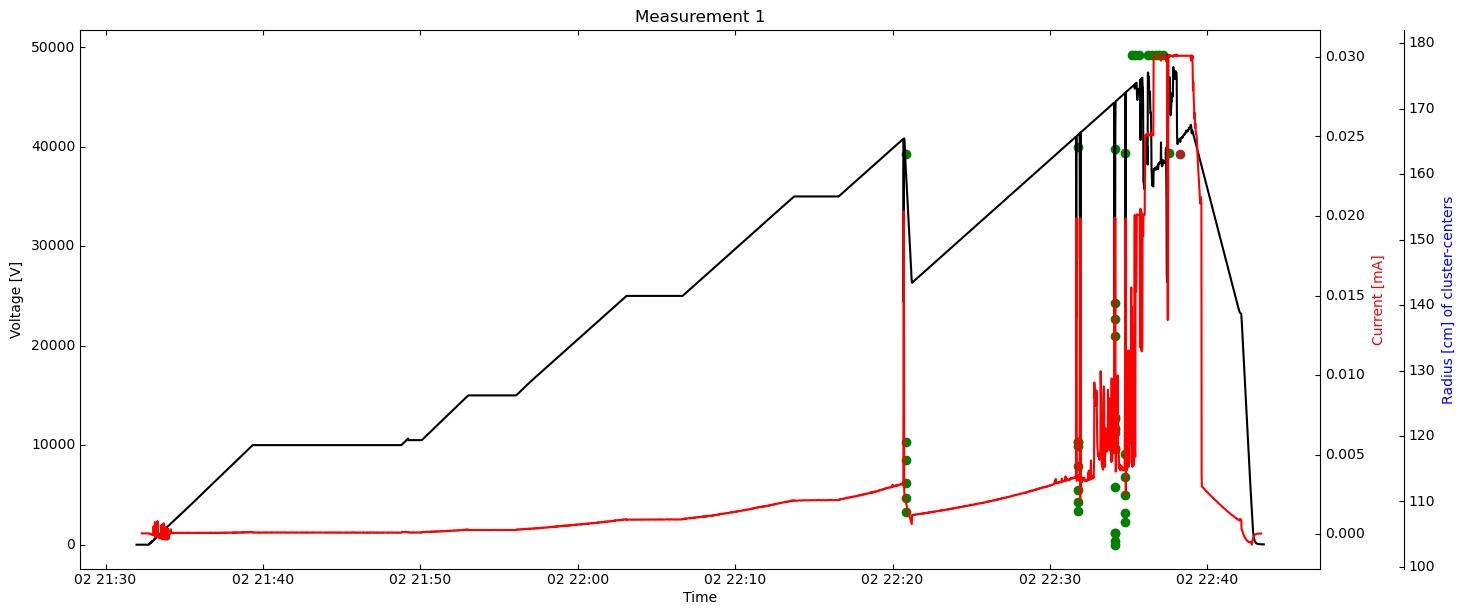

c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\tm3408\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return 

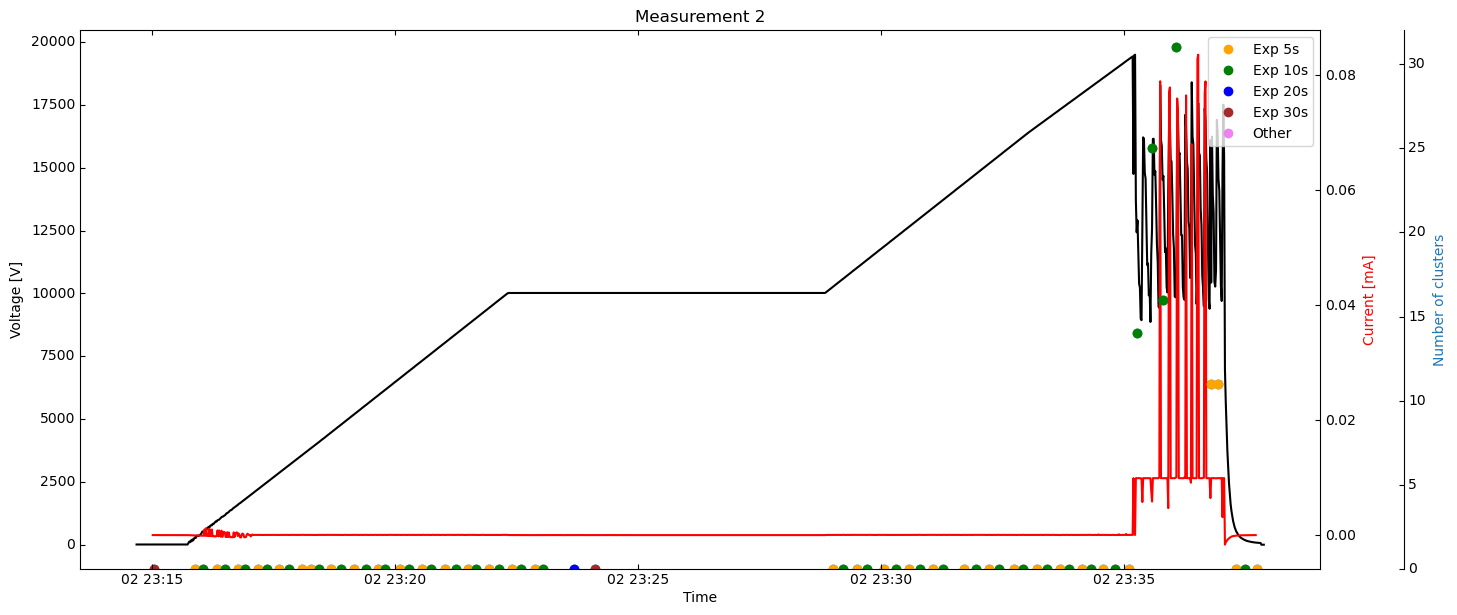

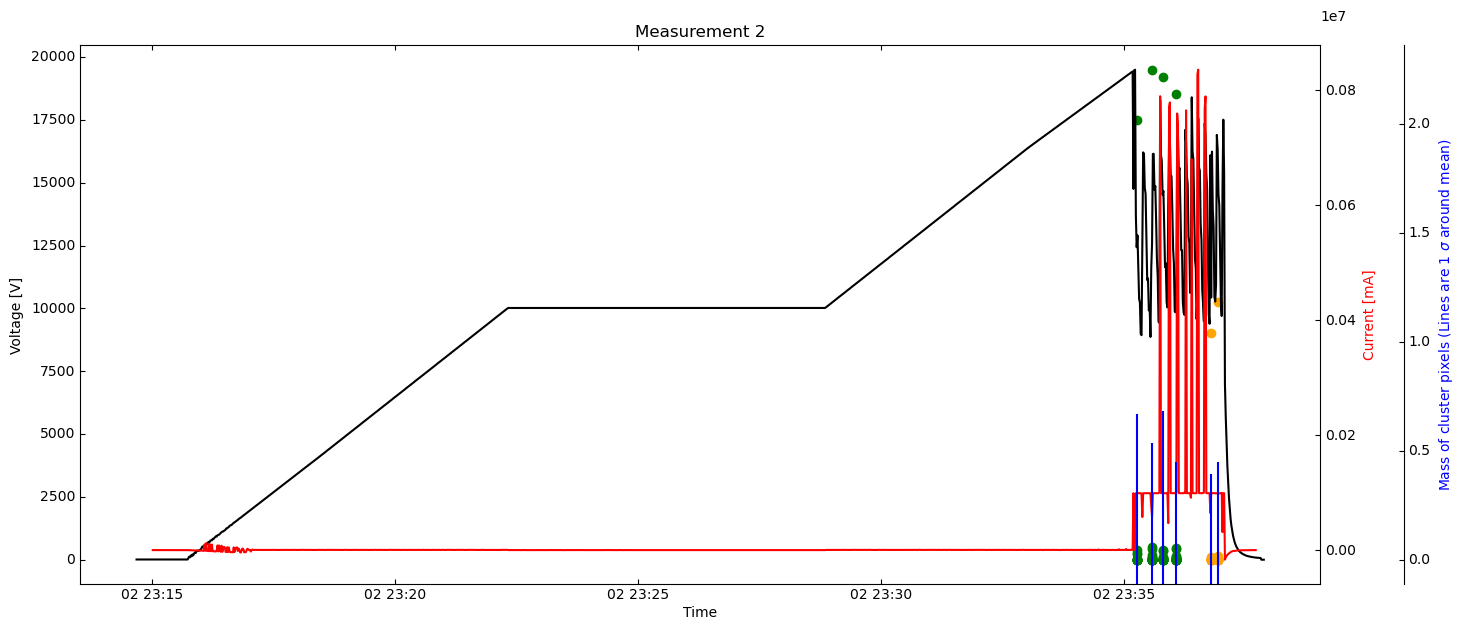

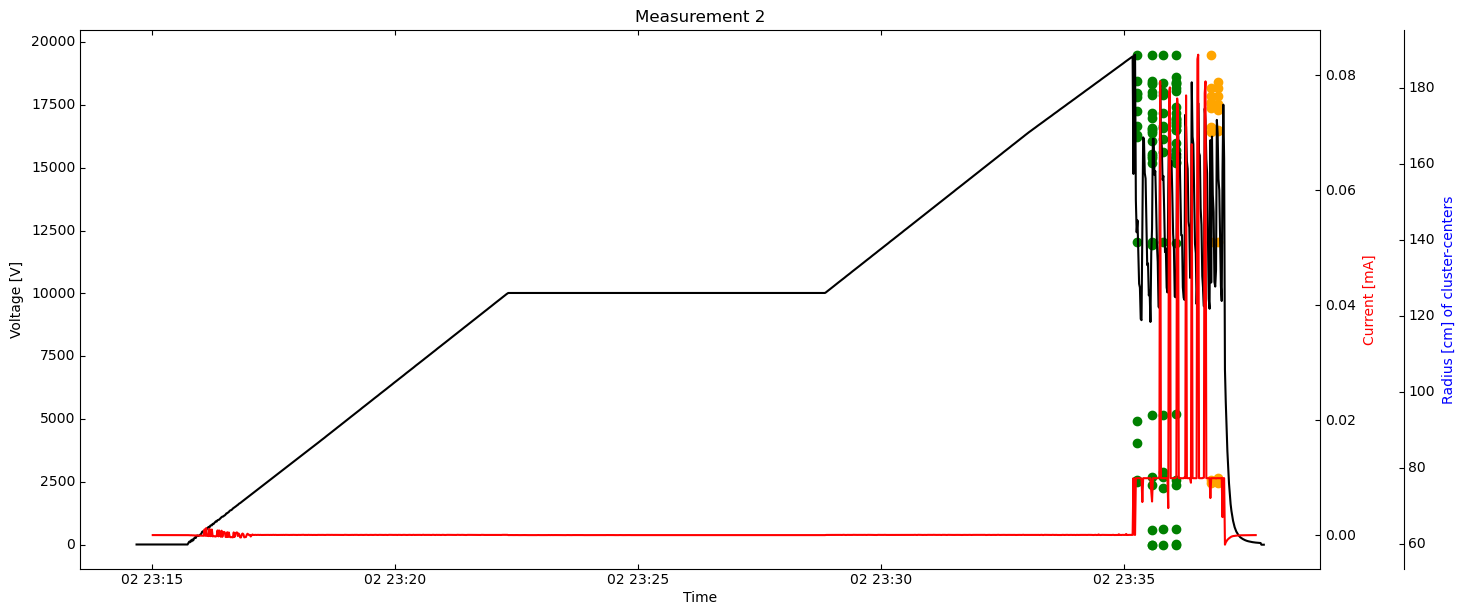

In [4]:
for id, run in enumerate(campaign.runs[:-1]):
    voltage = run.hv_data['voltage']
    current = run.hv_data['current']
    time = run.hv_data['time']
    
    offset = 60

    img_time = np.array(run.image_data['time'])
    n_clusters = np.array(run.image_data['n_clusters'])
    exp5_ids = [i for i, t in enumerate(run.image_data['exposure']) if t == 5]
    exp10_ids = [i for i, t in enumerate(run.image_data['exposure']) if t == 10]
    exp20_ids = [i for i, t in enumerate(run.image_data['exposure']) if t == 20]
    exp30_ids = [i for i, t in enumerate(run.image_data['exposure']) if t == 30]
    exp_other_ids = [i for i, t in enumerate(run.image_data['exposure']) if t < 5]

    mass_sum = [sum(mlist) for mlist in run.image_data['masses']]
    mass_mean = [np.mean(mlist) for mlist in run.image_data['masses']]
    mass_std = [np.std(mlist) for mlist in run.image_data['masses']]
    # m per px = ~1.3m per 3712 px
    radii = [[np.sqrt(p[0]**2+p[1]**2) * 130./3712. for p in plist] for plist in run.image_data['cluster_positions']]

    fig1 = plt.figure(figsize=(16, 7))
    voltage_ax1 = host_subplot(111, axes_class=AA.Axes, figure=fig1)
    current_ax1 = voltage_ax1.twinx()

    fig2 = plt.figure(figsize=(16, 7))
    voltage_ax2 = host_subplot(111, axes_class=AA.Axes, figure=fig2)
    current_ax2 = voltage_ax2.twinx()

    fig3 = plt.figure(figsize=(16, 7))
    voltage_ax3 = host_subplot(111, axes_class=AA.Axes, figure=fig3)
    current_ax3 = voltage_ax3.twinx()

    for axis in [current_ax1, current_ax2, current_ax3]:
        axis.axis["right"].toggle(all=True)

    nclusters_ax = voltage_ax1.twinx()
    mass_ax = voltage_ax2.twinx()
    radius_ax = voltage_ax3.twinx()
    for i, axis in enumerate([nclusters_ax, mass_ax, radius_ax]):
        new_fixed_axis = axis.get_grid_helper().new_fixed_axis
        axis.axis["right"] = new_fixed_axis(loc="right", axes=axis, offset=(offset, 0))
        axis.axis["right"].toggle(all=True)

    p3, = nclusters_ax.plot(img_time, n_clusters, 'o')
    nclusters_ax.plot(img_time[exp5_ids], n_clusters[exp5_ids], 'o', label='Exp 5s', color='orange')
    nclusters_ax.plot(img_time[exp10_ids], n_clusters[exp10_ids], 'o', label='Exp 10s', color='green')
    nclusters_ax.plot(img_time[exp20_ids], n_clusters[exp20_ids], 'o', label='Exp 20s', color='blue')
    nclusters_ax.plot(img_time[exp30_ids], n_clusters[exp30_ids], 'o', label='Exp 30s', color='brown')
    nclusters_ax.plot(img_time[exp_other_ids], n_clusters[exp_other_ids], 'o', label='Other', color='violet')
    nclusters_ax.legend()
    mass_ax.errorbar(img_time, mass_mean, yerr=mass_std, marker='o', linestyle='none', color='blue', markersize=0)
    #mass_ax.plot(img_time, mass_sum, marker='o', linestyle='none', color='blue')
    for i, n in enumerate(n_clusters):
        if run.image_data['exposure'][i] == 5:
            mass_ax.scatter([img_time[i]]*n, run.image_data['masses'][i], color='orange', label='Exp 5s')
            radius_ax.scatter([img_time[i]]*n, radii[i], color='orange', label='Exp 5s')
        elif run.image_data['exposure'][i] == 10:
            mass_ax.scatter([img_time[i]]*n, run.image_data['masses'][i], color='green', label='Exp 10s')
            radius_ax.scatter([img_time[i]]*n, radii[i], color='green', label='Exp 10s')
        elif run.image_data['exposure'][i] == 20:
            mass_ax.scatter([img_time[i]]*n, run.image_data['masses'][i], color='blue', label='Exp 20s')
            radius_ax.scatter([img_time[i]]*n, radii[i], color='blue', label='Exp 20s')
        elif run.image_data['exposure'][i] == 30:
            mass_ax.scatter([img_time[i]]*n, run.image_data['masses'][i], color='brown', label='Exp 30s')
            radius_ax.scatter([img_time[i]]*n, radii[i], color='brown', label='Exp 30s')
        else:
            mass_ax.scatter([img_time[i]]*n, run.image_data['masses'][i], color='violet', label='Other')
            radius_ax.scatter([img_time[i]]*n, radii[i], color='violet', label='Other')

    for voltage_ax in [voltage_ax1, voltage_ax2, voltage_ax3]:
        p1, = voltage_ax.plot(time, -1*voltage, color='black')
        voltage_ax.axis["left"].label.set_color(p1.get_color())
        voltage_ax.set_ylabel('Voltage [V]')
        voltage_ax.set_xlabel('Time')
        voltage_ax.set_title(f'Measurement {id+1}')
    for current_ax in [current_ax1, current_ax2, current_ax3]:
        p2, = current_ax.plot(time[20:-10], -1*current[20:-10], color='red')
        current_ax.axis["right"].label.set_color(p2.get_color())
        current_ax.set_ylabel('Current [mA]')
    nclusters_ax.axis["right"].label.set_color(p3.get_color())
    nclusters_ax.set_ylabel('Number of clusters')
    nclusters_ax.set_ylim(0, max(n_clusters)+1)
    mass_ax.axis["right"].label.set_color('blue')
    mass_ax.set_ylabel(r'Mass of cluster pixels (Lines are 1 $\sigma$ around mean)')
    radius_ax.axis["right"].label.set_color('blue')
    radius_ax.set_ylabel('Radius [cm] of cluster-centers')
    plt.show()